# Telecom Churn Prediction

# Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, you will analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, your goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*

**Customer behaviour during churn:**

Customers usually do not decide to switch to another competitor instantly, but rather over a
period of time (this is especially applicable to high-value customers). In churn prediction, we
assume that there are three phases of customer lifecycle :

1. <u>The ‘good’ phase:</u> In this phase, the customer is happy with the service and behaves as usual.

2. <u>The ‘action’ phase:</u> The customer experience starts to sore in this phase, for e.g. he/she gets a compelling offer from a competitor, faces unjust charges, becomes unhappy with service quality etc. In this phase, the customer usually shows different behaviour than the ‘good’ months. It is crucial to identify high-churn-risk customers in this phase, since some corrective actions can be taken at this point (such as matching the competitor’s offer/improving the service quality etc.)

3. <u>The ‘churn’ phase:</u> In this phase, the customer is said to have churned. In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month (September) is the ‘churn’ phase.

#### Below steps will be folowed for evaluation
1. Loading dependencies & datasets

# 1. Loading dependencies & datasets

Lets start by loading our dependencies. We can keep adding any imports to this cell block, as we write mode and mode code.

In [274]:
!pip install sweetviz

  Obtaining dependency information for sweetviz from https://files.pythonhosted.org/packages/7b/d7/b83a6a5548f6fd028c18e198f116e0be641c0db72cc12b0d6ddb836d0fa4/sweetviz-2.2.1-py3-none-any.whl.metadata
  Obtaining dependency information for importlib-resources>=1.2.0 from https://files.pythonhosted.org/packages/65/6e/09d8816b5cb7a4006ef8ad1717a2703ad9f331dae9717d9f22488a2d6469/importlib_resources-6.1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 4.1 MB/s eta 0:00:00m eta 0:00:010:01:01


In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

### For installing missingno library, type this command in terminal
#pip install missingno

import missingno as msno

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Class Imbalance
from imblearn.over_sampling import SMOTE

#Others
import warnings
warnings.filterwarnings('ignore')

import sweetviz as sv

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, I will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

### Derived attribute related functions

In [2]:
#The above data is with respect to data recharge
# We can create new column indicating data recharge and substitute null columns with 0 value


def create_data_rechange_info(df):
    df['data_rechange_6'] = df['date_of_last_rech_data_6'].isnull()
    df['data_rechange_7'] = df['date_of_last_rech_data_7'].isnull()
    df['data_rechange_8'] = df['date_of_last_rech_data_8'].isnull()

    del df['date_of_last_rech_data_6']
    del df['date_of_last_rech_data_7']
    del df['date_of_last_rech_data_8']

    df_len = len(df)*0.7
    i=0
    for col in df.columns:
        if df[col].isnull().sum() >= df_len:
            df[col].fillna(0)
    return df

def create_last_rechange_days(df):
    df['last_recharge_days'] = (pd.to_datetime('2014-08-31') - df[['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']].apply(pd.to_datetime).max(axis=1)).dt.days
    del df['date_of_last_rech_6']
    del df['date_of_last_rech_7']
    del df['date_of_last_rech_8']
    return df

def create_new_variables(df):
    df = create_data_rechange_info(df)
    df = create_last_rechange_days(df)
    return df

## Set display limits
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
#COMMENT THIS SECTION INCASE RUNNING THIS NOTEBOOK LOCALLY

#Checking the kaggle paths for the uploaded datasets
#import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
#INCASE RUNNING THIS LOCALLY, PASS THE RELATIVE PATH OF THE CSV FILES BELOW
#(e.g. if files are in same folder as notebook, simple write "train.csv" as path)

data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

#data = pd.read_csv("train.csv")
#unseen = pd.read_csv("test.csv")
#sample = pd.read_csv("sample.csv")
#data_dict = pd.read_csv("data_dictionary.csv")


print('Train data shape - ',data.shape)
print('Test data shape - ',unseen.shape)
print('Sample data shape - ',sample.shape)
print('Data dictionary shape - ', data_dict.shape)

Train data shape -  (69999, 172)
Test data shape -  (30000, 171)
Sample data shape -  (30000, 2)
Data dictionary shape -  (36, 2)


In [5]:

import sweetviz as sv
report = sv.analyze(data, pairwise_analysis='off')
report.show_html('sweet_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report sweet_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [198]:
data.describe()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
count,69999.000000,69999.0,69297.0,69297.0,69297.0,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.0,67312.0,66296.0,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,67231.000000,67312.000000,66296.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,69999.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,17568.000000,17865.000000,18417.000000,69999.000000,69999.000000

### Check data type of columns

In [199]:
data.info()
# data type are correctly assigned

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69999 entries, 0 to 69998
Columns: 172 entries, id to churn_probability
dtypes: float64(135), int64(28), object(9)
memory usage: 91.9+ MB


### Columns with NULL value

In [200]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

loc_og_t2o_mou                702
std_og_t2o_mou                702
loc_ic_t2o_mou                702
last_date_of_month_7          399
last_date_of_month_8          733
onnet_mou_6                  2768
onnet_mou_7                  2687
onnet_mou_8                  3703
offnet_mou_6                 2768
offnet_mou_7                 2687
offnet_mou_8                 3703
roam_ic_mou_6                2768
roam_ic_mou_7                2687
roam_ic_mou_8                3703
roam_og_mou_6                2768
roam_og_mou_7                2687
roam_og_mou_8                3703
loc_og_t2t_mou_6             2768
loc_og_t2t_mou_7             2687
loc_og_t2t_mou_8             3703
loc_og_t2m_mou_6             2768
loc_og_t2m_mou_7             2687
loc_og_t2m_mou_8             3703
loc_og_t2f_mou_6             2768
loc_og_t2f_mou_7             2687
loc_og_t2f_mou_8             3703
loc_og_t2c_mou_6             2768
loc_og_t2c_mou_7             2687
loc_og_t2c_mou_8             3703
loc_og_mou_6  

## 2. Data cleaning and formatting

### Delete columns with only one value

In [201]:
df_len = len(data)*0.9
i=0
for col in data.columns:
    if len(data[col].value_counts()) == 1:
        print(data[col].value_counts())

circle_id
109    69999
Name: count, dtype: int64
loc_og_t2o_mou
0.0    69297
Name: count, dtype: int64
std_og_t2o_mou
0.0    69297
Name: count, dtype: int64
loc_ic_t2o_mou
0.0    69297
Name: count, dtype: int64
last_date_of_month_6
6/30/2014    69999
Name: count, dtype: int64
last_date_of_month_7
7/31/2014    69600
Name: count, dtype: int64
last_date_of_month_8
8/31/2014    69266
Name: count, dtype: int64
std_og_t2c_mou_6
0.0    67231
Name: count, dtype: int64
std_og_t2c_mou_7
0.0    67312
Name: count, dtype: int64
std_og_t2c_mou_8
0.0    66296
Name: count, dtype: int64
std_ic_t2o_mou_6
0.0    67231
Name: count, dtype: int64
std_ic_t2o_mou_7
0.0    67312
Name: count, dtype: int64
std_ic_t2o_mou_8
0.0    66296
Name: count, dtype: int64


In [202]:
pd.set_option('display.max_columns', None)

In [203]:
data[data['loc_og_t2o_mou'].isnull()]['churn_probability'].value_counts()

churn_probability
1    535
0    167
Name: count, dtype: int64

In [204]:
df_len = len(data)*0.9
i=0
for col in data.columns:
    if len(data[col].value_counts()) == 1:
        i=i+1
        print(i,'.', col,'.',data[col][0],'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . circle_id . 109 . 100.0 %
2 . loc_og_t2o_mou . 0.0 . 99.0 %
3 . std_og_t2o_mou . 0.0 . 99.0 %
4 . loc_ic_t2o_mou . 0.0 . 99.0 %
5 . last_date_of_month_6 . 6/30/2014 . 100.0 %
6 . last_date_of_month_7 . 7/31/2014 . 99.43 %
7 . last_date_of_month_8 . 8/31/2014 . 98.95 %
8 . std_og_t2c_mou_6 . 0.0 . 96.05 %
9 . std_og_t2c_mou_7 . 0.0 . 96.16 %
10 . std_og_t2c_mou_8 . 0.0 . 94.71 %
11 . std_ic_t2o_mou_6 . 0.0 . 96.05 %
12 . std_ic_t2o_mou_7 . 0.0 . 96.16 %
13 . std_ic_t2o_mou_8 . 0.0 . 94.71 %


### Delete columns with more than 90% same values

In [205]:
df_len = len(data)*0.9
i=0
l = []
for col in data.columns:
    if data[col].value_counts().iloc[0] >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].value_counts().iloc[0],'.',round(data[col].value_counts().iloc[0]*100/len(data),2),'%')
        del data[col]

1 . isd_og_mou_6 . 63897 . 91.28 %
2 . isd_og_mou_7 . 64180 . 91.69 %
3 . isd_og_mou_8 . 63384 . 90.55 %
4 . og_others_7 . 67072 . 95.82 %
5 . og_others_8 . 65996 . 94.28 %
6 . monthly_2g_6 . 64896 . 92.71 %
7 . monthly_2g_7 . 64695 . 92.42 %
8 . monthly_2g_8 . 64817 . 92.6 %
9 . monthly_3g_6 . 65990 . 94.27 %
10 . monthly_3g_7 . 66062 . 94.38 %
11 . monthly_3g_8 . 65789 . 93.99 %
12 . sachet_3g_6 . 67088 . 95.84 %
13 . sachet_3g_7 . 67101 . 95.86 %
14 . sachet_3g_8 . 67059 . 95.8 %


In [206]:
df_len = len(data)*0.7
i=0
print('Columns with more than 70% missing values')
for col in data.columns:
    if data[col].isnull().sum() >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].isnull().sum(),'.', round((data[col].isnull().sum()/len(data))*100,2))
        #del data[col]

Columns with more than 70% missing values
1 . date_of_last_rech_data_6 . 52431 . 74.9
2 . date_of_last_rech_data_7 . 52134 . 74.48
3 . date_of_last_rech_data_8 . 51582 . 73.69
4 . total_rech_data_6 . 52431 . 74.9
5 . total_rech_data_7 . 52134 . 74.48
6 . total_rech_data_8 . 51582 . 73.69
7 . max_rech_data_6 . 52431 . 74.9
8 . max_rech_data_7 . 52134 . 74.48
9 . max_rech_data_8 . 51582 . 73.69
10 . count_rech_2g_6 . 52431 . 74.9
11 . count_rech_2g_7 . 52134 . 74.48
12 . count_rech_2g_8 . 51582 . 73.69
13 . count_rech_3g_6 . 52431 . 74.9
14 . count_rech_3g_7 . 52134 . 74.48
15 . count_rech_3g_8 . 51582 . 73.69
16 . av_rech_amt_data_6 . 52431 . 74.9
17 . av_rech_amt_data_7 . 52134 . 74.48
18 . av_rech_amt_data_8 . 51582 . 73.69
19 . arpu_3g_6 . 52431 . 74.9
20 . arpu_3g_7 . 52134 . 74.48
21 . arpu_3g_8 . 51582 . 73.69
22 . arpu_2g_6 . 52431 . 74.9
23 . arpu_2g_7 . 52134 . 74.48
24 . arpu_2g_8 . 51582 . 73.69
25 . night_pck_user_6 . 52431 . 74.9
26 . night_pck_user_7 . 52134 . 74.48
27 . n

#### <span style="color:blue">Observation :-</span>
Since same count of data for rechange related columns are missing, hence will not delete it.
Will handle in derived data section.
Create new attribute to indicate has data recharge or not and consider default value for NA cell as Zero.

In [207]:
data = create_data_rechange_info(data)
unseen = create_data_rechange_info(unseen)

### Removing columns not required for analysis

In [208]:
del data['id'] # primary key

### Removing rows with all null values in July, Aug, Sept

In [209]:
# Get all unique prefixes from column names
prefixes = set('_'.join(col.split('_')[0:-1]) for col in data.columns if col.split('_')[-1] in ['6','7','8'])
# Create a list to store filtered DataFrames for each prefix
filtered_dfs = []
print('Shape before row delete - ', data.shape)
# Iterate over prefixes and filter rows where all columns with the same prefix are null
for prefix in prefixes:
    # Get columns with the current prefix
    cols_with_prefix = [col for col in data.columns if col.startswith(prefix)]
    
    # Filter rows where all columns with the same prefix are null
    filtered_df = data[data[cols_with_prefix].isnull().all(axis=1)]
    if len(filtered_df) > 0:
        print(prefix,'_*', ' count - ', len(filtered_df))
    # Append the filtered DataFrame to the list
    data = data[~data[cols_with_prefix].isnull().all(axis=1)]
    
print('Shape after row delete - ', data.shape)

Shape before row delete -  (69999, 144)
offnet_mou _*  count -  758
total_rech_data _*  count -  43478
og_others _*  count -  683
Shape after row delete -  (25080, 144)


### Check for duplicates

In [210]:
data[data.duplicated()]

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8


### Add default value 0 to numerical values

In [211]:
for col in data.select_dtypes(include=['float']):
    data[col] = data[col].fillna(0)

In [212]:
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

date_of_last_rech_6     89
date_of_last_rech_7    181
date_of_last_rech_8    503
dtype: int64

### Derived attributes

In [213]:
df_len = len(data)*0.7
i=0
print('Columns with more than 50% missing values')
for col in data.columns:
    if data[col].isnull().sum() >= df_len:
        i=i+1
        print(i,'.', col,'.',data[col].isnull().sum(),'.', round((data[col].isnull().sum()/len(data))*100,2))

Columns with more than 50% missing values


#### <span style="color:blue">Observation :-</span>
The value in above columns is only for data rechange related columns
So we can create a column to depict data recharge and fill null numerical values with 0 instead of NA

### derive last recharge in days from dates

In [214]:
data = create_last_rechange_days(data)
unseen = create_last_rechange_days(unseen)

In [215]:
## Columns with Null values
filtered_data = data.loc[:, data.isnull().sum() != 0]
filtered_data.isnull().sum()

Series([], dtype: float64)

In [216]:
pd.set_option('display.max_rows', None)

In [217]:
data[data['onnet_mou_8'].isnull()]['churn_probability'].value_counts()

Series([], Name: count, dtype: int64)

In [218]:
data['churn_probability'].value_counts()

churn_probability
0    23227
1     1853
Name: count, dtype: int64

In [219]:
## Columns with Null values
filtered_data = unseen.loc[:, unseen.isnull().sum() != 0]
filtered_data.isnull().sum()

loc_og_t2o_mou            316
std_og_t2o_mou            316
loc_ic_t2o_mou            316
last_date_of_month_7      202
last_date_of_month_8      367
onnet_mou_6              1169
onnet_mou_7              1172
onnet_mou_8              1675
offnet_mou_6             1169
offnet_mou_7             1172
offnet_mou_8             1675
roam_ic_mou_6            1169
roam_ic_mou_7            1172
roam_ic_mou_8            1675
roam_og_mou_6            1169
roam_og_mou_7            1172
roam_og_mou_8            1675
loc_og_t2t_mou_6         1169
loc_og_t2t_mou_7         1172
loc_og_t2t_mou_8         1675
loc_og_t2m_mou_6         1169
loc_og_t2m_mou_7         1172
loc_og_t2m_mou_8         1675
loc_og_t2f_mou_6         1169
loc_og_t2f_mou_7         1172
loc_og_t2f_mou_8         1675
loc_og_t2c_mou_6         1169
loc_og_t2c_mou_7         1172
loc_og_t2c_mou_8         1675
loc_og_mou_6             1169
loc_og_mou_7             1172
loc_og_mou_8             1675
std_og_t2t_mou_6         1169
std_og_t2t

In [220]:
# Checking the related columns values
data[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].head(10)

,arpu_3g_6,arpu_2g_6,av_rech_amt_data_6
1,0.00,0.00,0.0
4,0.00,0.00,175.0
7,0.00,0.00,198.0
10,202.27,14.38,98.0
15,0.00,164.75,154.0
16,122.58,122.07,145.0
24,0.00,0.10,23.0
27,79.35,0.18,205.0
32,0.00,0.76,75.0
39,0.00,0.01,308.0


In [221]:
print("Correlation table for month 6\n\n", data[['arpu_3g_6','arpu_2g_6','av_rech_amt_data_6']].corr())
print("\nCorrelation table for month 7\n\n", data[['arpu_3g_7','arpu_2g_7','av_rech_amt_data_7']].corr())
print("\nCorrelation table for month 8\n\n", data[['arpu_3g_8','arpu_2g_8','av_rech_amt_data_8']].corr())

Correlation table for month 6

                     arpu_3g_6  arpu_2g_6  av_rech_amt_data_6
arpu_3g_6            1.000000   0.930508            0.791899
arpu_2g_6            0.930508   1.000000            0.823100
av_rech_amt_data_6   0.791899   0.823100            1.000000

Correlation table for month 7

                     arpu_3g_7  arpu_2g_7  av_rech_amt_data_7
arpu_3g_7            1.000000   0.935250            0.785758
arpu_2g_7            0.935250   1.000000            0.804542
av_rech_amt_data_7   0.785758   0.804542            1.000000

Correlation table for month 8

                     arpu_3g_8  arpu_2g_8  av_rech_amt_data_8
arpu_3g_8            1.000000   0.929534            0.781540
arpu_2g_8            0.929534   1.000000            0.795812
av_rech_amt_data_8   0.781540   0.795812            1.000000


 <span style="color:blue">Observation</span> <p>From the correlation table above, it's evident that the attributes <code>arpu_2g_*</code> and <code>arpu_3g_*</code> for each month from 6 to 9 are strongly correlated with the attribute <code>av_rech_amt_data_*</code> for the same respective months.</p>
<p>Given the substantial correlation between these variables, it is a prudent decision to consider dropping the attributes <code>arpu_2g_*</code> and <code>arpu_3g_*</code>.</p>


In [222]:
# Dropping the columns 'arpu_3g_6'&'arpu_2g_6' in the sixth month data
data.drop(['arpu_3g_6','arpu_2g_6'],axis=1, inplace=True)

# Dropping the columns 'arpu_3g_7'&'arpu_2g_7' in the seventh month data
data.drop(['arpu_3g_7','arpu_2g_7'],axis=1, inplace=True)

# Dropping the columns 'arpu_3g_8'&'arpu_2g_8' in the eigth month data
data.drop(['arpu_3g_8','arpu_2g_8'],axis=1, inplace=True)

<p>In the dataset, it is noteworthy that the column <code>fb_user_*</code> and <code>night_pck</code> for each month from 6 to 8 respectively demonstrates a missing value percentage exceeding 50%. Moreover, these columns do not appear to provide substantial information for data comprehension.</p>
<p>As a result, it is statistically prudent to consider excluding these columns from further analysis.</p>


In [ ]:
data.drop(['fb_user_6','fb_user_7','fb_user_8'], axis=1, inplace=True)

In [270]:
data.drop(['night_pck_user_6','night_pck_user_7','night_pck_user_8'],
                  axis=1, inplace=True)

In [271]:
# Let us check the unique values for the columns to filter out further before scaling
data.nunique().sort_values(ascending=True)

data_rechange_7                2
churn_probability              2
data_rechange_6                2
data_rechange_8                2
total_rech_num_group_8         4
total_rech_data_group_6        4
total_rech_num_group_7         4
total_rech_num_group_6         4
total_rech_data_group_8        4
total_rech_data_group_7        4
tenure_range                   5
count_rech_3g_6               23
count_rech_3g_7               27
count_rech_3g_8               29
total_rech_data_6             37
total_rech_data_7             42
total_rech_data_8             45
max_rech_data_7               46
max_rech_data_6               48
max_rech_data_8               50
spl_ic_mou_6                  75
total_rech_num_8              78
total_rech_num_6              80
spl_ic_mou_8                  81
total_rech_num_7              83
last_recharge_days            86
spl_ic_mou_7                  92
tenure                       128
last_day_rch_amt_6           135
last_day_rch_amt_7           136
max_rech_a

## 3. Exploratory Data analysis 

### Univariant analysis

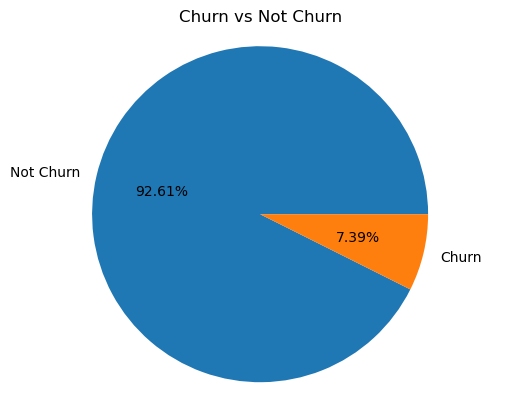

In [223]:
plt.pie(data['churn_probability'].value_counts().values,labels=['Not Churn','Churn'], autopct='%.2f%%')
plt.axis('equal')
plt.title('Churn vs Not Churn')
plt.show()

> <span style="color:blue">Observation</span> - Only 10% of data has churn related information hence class imbalance handling techniques to be used

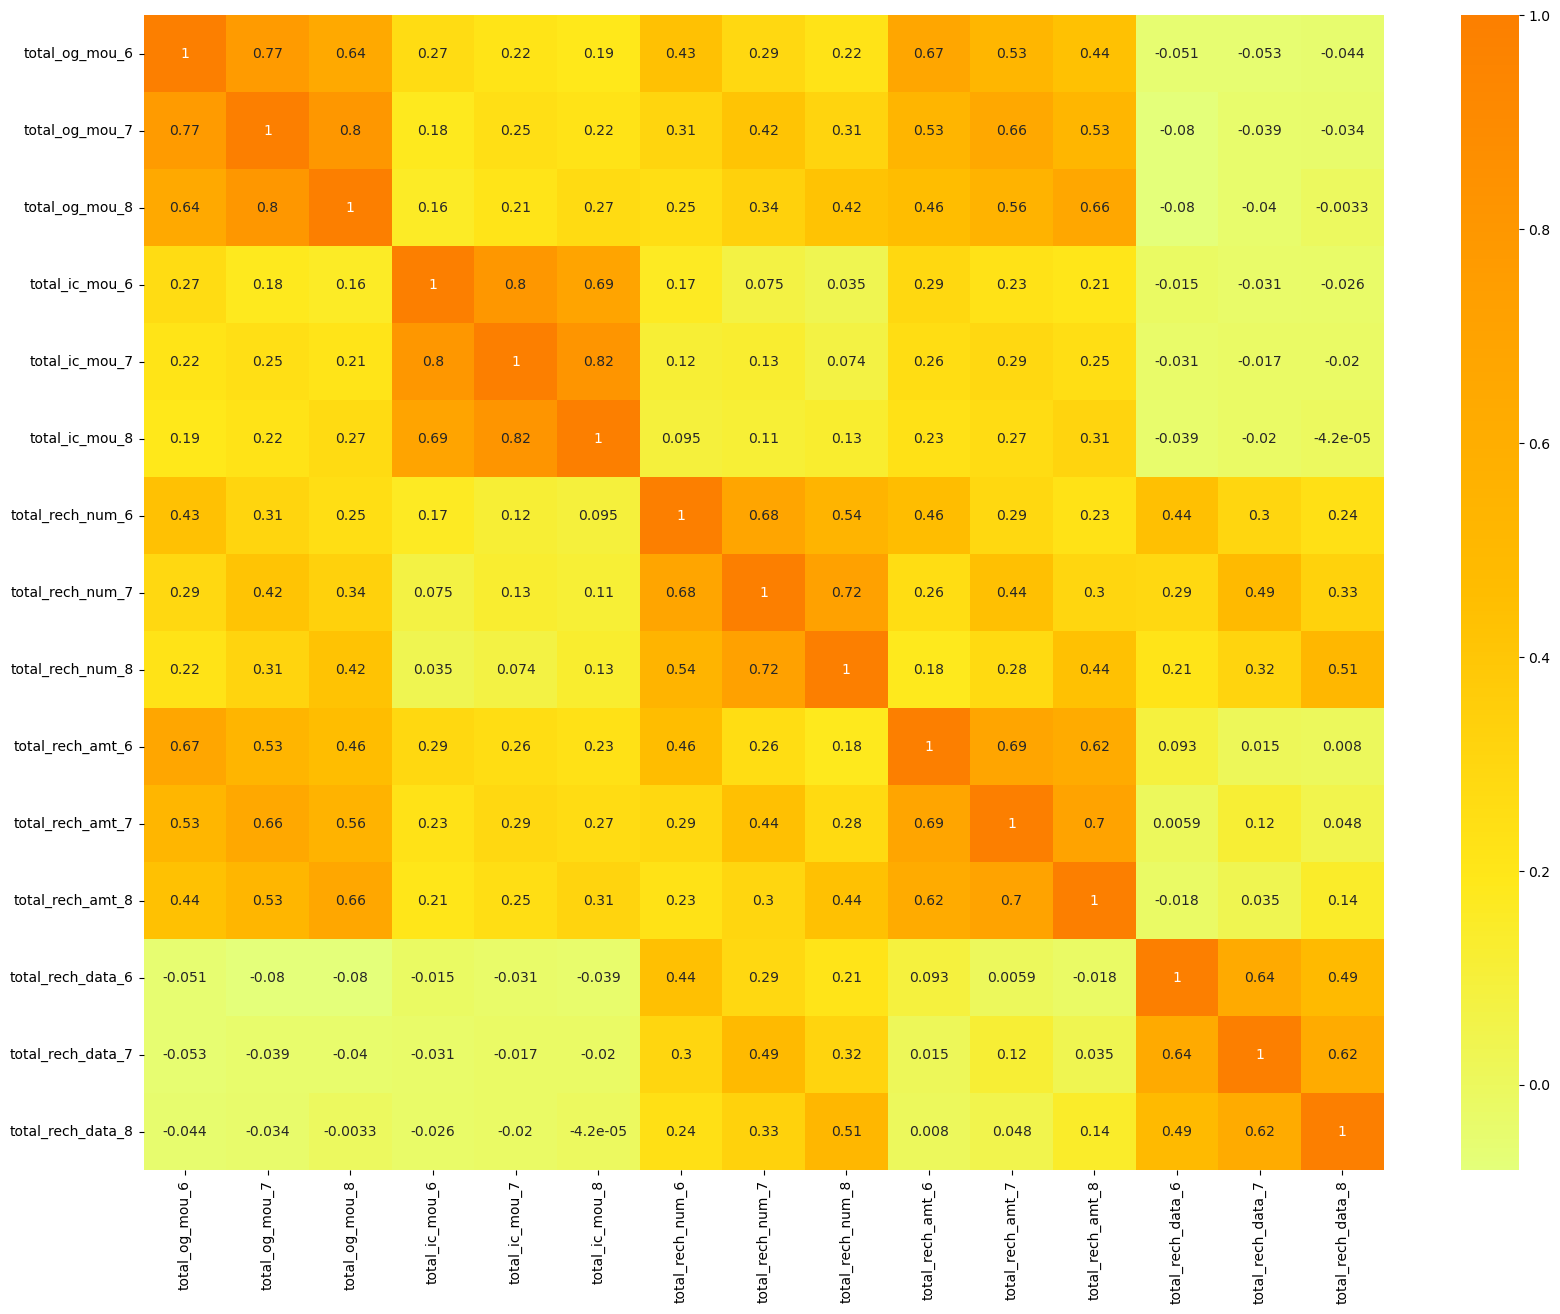

In [224]:
# Get all unique prefixes from column names
month_columns = list(col for col in data.columns if 'total' in col)

# figure size
plt.figure(figsize=(20, 15))

# heatmap
sns.heatmap(data[month_columns].corr(), cmap="Wistia", annot=True)
plt.show()

### Drop month related columns which are highly correlated with total

In [225]:
correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.7
total_columns = set(col for col in data.columns if 'total' in col)
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in total_columns:
    for j in month_columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

loc_ic_mou_6  ---  0.9060582713415822
loc_ic_t2m_mou_6  ---  0.7394408480640354
loc_ic_mou_7  ---  0.7404409940635844
count_rech_2g_7  ---  0.907671482876096
sachet_2g_7  ---  0.9017094534066104
loc_ic_t2m_mou_8  ---  0.7477556213807849
loc_ic_mou_8  ---  0.9049756080087973
loc_ic_mou_7  ---  0.7473200325506825
arpu_6  ---  0.7147206590710588
arpu_7  ---  0.9621969161600878
arpu_8  ---  0.7514431708519325
offnet_mou_8  ---  0.770575290477654
std_og_mou_8  ---  0.8253111909022002
onnet_mou_8  ---  0.7850677125799405
onnet_mou_6  ---  0.7515953578571605
offnet_mou_6  ---  0.7940871440151924
std_og_mou_6  ---  0.811434739015154
std_og_mou_7  ---  0.8319454932010079
offnet_mou_7  ---  0.7846761798924299
onnet_mou_7  ---  0.7659742106233287
loc_ic_t2m_mou_7  ---  0.7241074384323143
loc_ic_mou_8  ---  0.7519027894887798
loc_ic_mou_6  ---  0.725959497899567
loc_ic_mou_7  ---  0.902331062936491
count_rech_2g_6  ---  0.9071645509406513
sachet_2g_6  ---  0.8996779094582372
arpu_6  ---  0.9598727

### Drop month related columns which are highly correlated

correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.8
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in month_columns:
    for j in month_columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

correlation_matrix = data.corr()

# Set the correlation threshold (adjust as needed)
correlation_threshold = 0.80
month_columns = set(col for col in data.columns if 'total' not in col and col.split('_')[-1] in ['6','7','8'])

# Find columns with high correlation
highly_correlated_columns = set()
for i in data.columns:
    for j in data.columns:
        if abs(correlation_matrix[i][j]) > correlation_threshold and i!=j:
            print(j," --- ",correlation_matrix[i][j])
            highly_correlated_columns.add(j)

# 'highly_correlated_columns' now contains the names of columns with high correlation
print(highly_correlated_columns)

data.drop(columns=highly_correlated_columns, inplace=True)

In [226]:
data.columns

Index(['roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6',
       'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_6',
       ...
       'fb_user_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'churn_probability', 'data_rechange_6', 'data_rechange_7',
       'data_rechange_8', 'last_recharge_days'],
      dtype='object', length=112)

In [227]:
data_dict

,Acronyms,Description
0,CIRCLE_ID,Telecom circle area to which the customer belo...
1,LOC,Local calls within same telecom circle
2,STD,STD calls outside the calling circle
3,IC,Incoming calls
4,OG,Outgoing calls
5,T2T,Operator T to T ie within same operator mobile...
6,T2M,Operator T to other operator mobile
7,T2O,Operator T to other operator fixed line
8,T2F,Operator T to fixed lines of T
9,T2C,Operator T to its own call center


In [228]:
data.head()

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8,last_recharge_days
1,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,22.01,29.79,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,30.73,31.66,0.0,0.00,30.73,31.66,1.68,19.09,10.53,0.35,1.66,3.40,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,3.44,39.44,25.04,0.0,0.0,0.01,0.0,0.0,0.0,0.0,0.0,0.0,3,4,5,0,145,50,0,145,50,0,0,0,0.0,1.0,0.0,0.0,145.0,0.0,0.0,1.0,0.0,0.0,145.0,0.0,0.00,352.91,0.00,0.00,3.96,0.0,0.0,0.0,0.0,0.0,1.0,0.0,710,0.00,0.00,0.00,0,True,False,True,5
4,53.64,0.0,0.0,15.73,0.0,0.0,10.16,4.83,6.13,36.74,19.88,4.61,11.99,1.23,5.01,0.0,9.85,0.00,58.91,25.94,15.76,0.0,0.0,0.0,4.35,0.00,0.00,0.0,0.0,0.00,0.00,17.00,0.00,0.0,63.26,42.94,15.76,5.44,1.39,2.66,5.51,3.63,6.14,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,21.54,9.36,28.31,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,13,10,8,290,136,122,50,41,30,25,10,30,7.0,7.0,6.0,25.0,41.0,25.0,0.0,1.0,0.0,175.0,191.0,142.0,390.80,308.89,213.47,0.00,0.00,0.0,0.0,0.0,0.0,1.0,1.0,1.0,647,0.00,0.00,0.00,0,False,False,False,1
7,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,11.36,6.04,28.44,0.00,0.00,4.14,0.0,0.0,0.0,0.00,0.00,0.0,0.33,0.68,2.49,0.33,0.68,2.49,25.11,15.89,43.83,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,2,3,2,198,198,198,198,198,198,198,198,0,1.0,1.0,1.0,198.0,198.0,198.0,0.0,0.0,0.0,198.0,198.0,198.0,167.53,6.29,5.40,177.90,151.58,271.4,0.0,0.0,0.0,1.0,1.0,1.0,584,82.26,73.56,177.14,0,False,False,False,3
10,18.56,0.0,0.0,20.30,0.0,0.0,16.54,0.00,0.00,47.36,1.44,0.00,25.98,0.00,0.00,0.0,0.00,0.00,89.89,1.44,0.00,0.0,0.0,0.0,11.16,6.71,2.36,0.0,0.0,0.00,0.00,0.00,0.78,0.0,101.06,8.16,3.14,17.44,0.00,8.58,11.78,0.00,0.05,0.0,0.0,0.0,444.79,62.24,0.0,0.00,1.53,0.00,444.79,63.78,0.00,585.49,66.06,17.31,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,8,3,1,388,0,0,110,0,0,98,0,0,1.0,0.0,0.0,98.0,0.0,0.0,0.0,0.0,0.0,98.0,0.0,0.0,6.33,0.00,0.00,97.94,0.00,0.0,0.0,0.0,0.0,1.0,0.0,0.0,468,1.05,0.00,18.95,0,False,True,True,26
15,0.00,0.0,0.0,0.00,0.0,0.0,10.43,24.99,194.43,313.76,330.88,185.88,3.26,10.91,4.94,0.0,0.00,0.00,327.46,366.79,385.26,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,6.26,0.08,0.00,0.00,0.1,327.64,366.79,391.53,13.86,20.18,335.43,0.00,1

Let's look at each variable's datatype:

In [229]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 25080 entries, 1 to 69998
Data columns (total 112 columns):
 #    Column              Dtype  
---   ------              -----  
 0    roam_ic_mou_6       float64
 1    roam_ic_mou_7       float64
 2    roam_ic_mou_8       float64
 3    roam_og_mou_6       float64
 4    roam_og_mou_7       float64
 5    roam_og_mou_8       float64
 6    loc_og_t2t_mou_6    float64
 7    loc_og_t2t_mou_7    float64
 8    loc_og_t2t_mou_8    float64
 9    loc_og_t2m_mou_6    float64
 10   loc_og_t2m_mou_7    float64
 11   loc_og_t2m_mou_8    float64
 12   loc_og_t2f_mou_6    float64
 13   loc_og_t2f_mou_7    float64
 14   loc_og_t2f_mou_8    float64
 15   loc_og_t2c_mou_6    float64
 16   loc_og_t2c_mou_7    float64
 17   loc_og_t2c_mou_8    float64
 18   loc_og_mou_6        float64
 19   loc_og_mou_7        float64
 20   loc_og_mou_8        float64
 21   std_og_t2t_mou_6    float64
 22   std_og_t2t_mou_7    float64
 23   std_og_t2t_mou_8    float64
 24   std_o

Let's also summarize the features using the df.describe method:

In [230]:
data.describe(include="all")

,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,data_rechange_6,data_rechange_7,data_rechange_8,last_recharge_days
count,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.000000,25080.00000,25080.000000,25080.000000,25080.000000,25080,25080,25080,25080.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,2,2,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [231]:
# deriving columns with respect to service usage based on location
column=data.columns
all_loc_mou=[]
for c in column:
  if c.startswith("loc"):
    all_loc_mou.append(c)
  else:
    pass

all_loc_mou

['loc_og_t2t_mou_6',
 'loc_og_t2t_mou_7',
 'loc_og_t2t_mou_8',
 'loc_og_t2m_mou_6',
 'loc_og_t2m_mou_7',
 'loc_og_t2m_mou_8',
 'loc_og_t2f_mou_6',
 'loc_og_t2f_mou_7',
 'loc_og_t2f_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'loc_og_mou_6',
 'loc_og_mou_7',
 'loc_og_mou_8',
 'loc_ic_t2t_mou_6',
 'loc_ic_t2t_mou_7',
 'loc_ic_t2t_mou_8',
 'loc_ic_t2f_mou_6',
 'loc_ic_t2f_mou_7',
 'loc_ic_t2f_mou_8']

In [232]:
# mou for all loc calls
data['total_loc_mou'] = data[all_loc_mou].sum(axis=1)
data['total_loc_mou'].head()

1       88.51
4      235.81
7       49.98
10     220.50
15    2539.27
Name: total_loc_mou, dtype: float64

In [233]:
# deriving columns with respect to service usage based on standard call
all_std_mou=[]
for c in column:
  if c.startswith('std'):
    all_std_mou.append(c)
  else:
    pass

all_std_mou

['std_og_t2t_mou_6',
 'std_og_t2t_mou_7',
 'std_og_t2t_mou_8',
 'std_og_t2m_mou_6',
 'std_og_t2m_mou_7',
 'std_og_t2m_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_ic_t2t_mou_6',
 'std_ic_t2t_mou_7',
 'std_ic_t2t_mou_8',
 'std_ic_t2m_mou_6',
 'std_ic_t2m_mou_7',
 'std_ic_t2m_mou_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_mou_6',
 'std_ic_mou_7',
 'std_ic_mou_8']

In [234]:
# Creating the mou for all std calls
data['total_std_mou'] = data[all_std_mou].sum(axis=1)
data['total_std_mou'].head()

1        0.00
4        4.35
7        7.00
10    1037.36
15       8.32
Name: total_std_mou, dtype: float64

In [235]:
# selecting columns based on isd calls in month 6,7,8
all_isd_mou=[]
for c in column:
  if c.startswith('isd'):
    all_isd_mou.append(c)
  else:
    pass

all_isd_mou

['isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8']

In [236]:
# Creating the mou for all isd calls
data['total_isd_mou'] = data[all_isd_mou].sum(axis=1)
data['total_isd_mou'].head()

1     0.0
4     0.0
7     0.0
10    0.0
15    0.0
Name: total_isd_mou, dtype: float64

In [242]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 25080 entries, 1 to 69998
Data columns (total 115 columns):
 #    Column              Dtype  
---   ------              -----  
 0    roam_ic_mou_6       float64
 1    roam_ic_mou_7       float64
 2    roam_ic_mou_8       float64
 3    roam_og_mou_6       float64
 4    roam_og_mou_7       float64
 5    roam_og_mou_8       float64
 6    loc_og_t2t_mou_6    float64
 7    loc_og_t2t_mou_7    float64
 8    loc_og_t2t_mou_8    float64
 9    loc_og_t2m_mou_6    float64
 10   loc_og_t2m_mou_7    float64
 11   loc_og_t2m_mou_8    float64
 12   loc_og_t2f_mou_6    float64
 13   loc_og_t2f_mou_7    float64
 14   loc_og_t2f_mou_8    float64
 15   loc_og_t2c_mou_6    float64
 16   loc_og_t2c_mou_7    float64
 17   loc_og_t2c_mou_8    float64
 18   loc_og_mou_6        float64
 19   loc_og_mou_7        float64
 20   loc_og_mou_8        float64
 21   std_og_t2t_mou_6    float64
 22   std_og_t2t_mou_7    float64
 23   std_og_t2t_mou_8    float64
 24   std_o

In [243]:
data['total_rech_data_group_6']=pd.cut(data['total_rech_data_6'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_data_group_7']=pd.cut(data['total_rech_data_7'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_data_group_8']=pd.cut(data['total_rech_data_8'],[-1,0,10,25,100],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

data['total_rech_num_group_6']=pd.cut(data['total_rech_num_6'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_num_group_7']=pd.cut(data['total_rech_num_7'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])
data['total_rech_num_group_8']=pd.cut(data['total_rech_num_8'],[-1,0,10,25,1000],labels=["No_Recharge","<=10_Recharges","10-25_Recharges",">25_Recharges"])

data[['total_rech_data_6','total_rech_data_group_6','total_rech_data_7','total_rech_data_group_7','total_rech_data_8','total_rech_data_group_8',
              'total_rech_num_6','total_rech_num_group_6','total_rech_num_7','total_rech_num_group_7','total_rech_num_8','total_rech_num_group_8']].head()


,total_rech_data_6,total_rech_data_group_6,total_rech_data_7,total_rech_data_group_7,total_rech_data_8,total_rech_data_group_8,total_rech_num_6,total_rech_num_group_6,total_rech_num_7,total_rech_num_group_7,total_rech_num_8,total_rech_num_group_8
1,0.0,No_Recharge,1.0,<=10_Recharges,0.0,No_Recharge,3,<=10_Recharges,4,<=10_Recharges,5,<=10_Recharges
4,7.0,<=10_Recharges,7.0,<=10_Recharges,6.0,<=10_Recharges,13,10-25_Recharges,10,<=10_Recharges,8,<=10_Recharges
7,1.0,<=10_Recharges,1.0,<=10_Recharges,1.0,<=10_Recharges,2,<=10_Recharges,3,<=10_Recharges,2,<=10_Recharges
10,1.0,<=10_Recharges,0.0,No_Recharge,0.0,No_Recharge,8,<=10_Recharges,3,<=10_Recharges,1,<=10_Recharges
15,1.0,<=10_Recharges,0.0,No_Recharge,1.0,<=10_Recharges,5,<=10_Recharges,3,<=10_Recharges,4,<=10_Recharges


					Distribution of total_rech_data_6 variable
 total_rech_data_group_6
<=10_Recharges     16706
No_Recharge         7944
10-25_Recharges      415
>25_Recharges         15
Name: count, dtype: int64


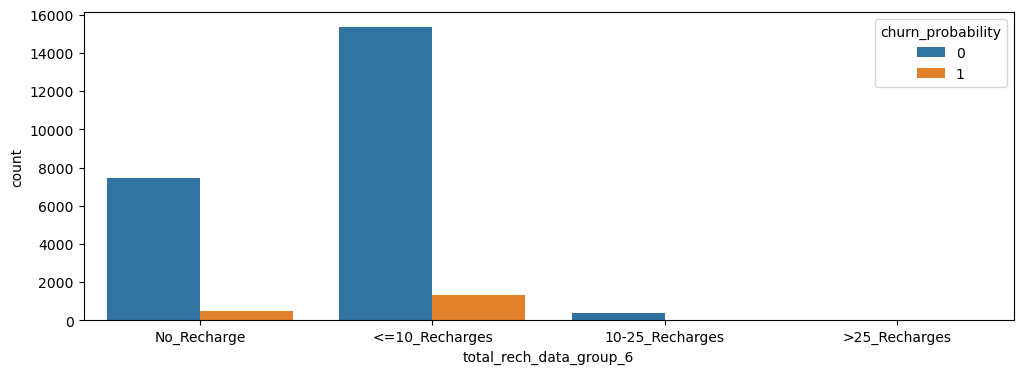




					Distribution of total_rech_data_6 variable
 total_rech_data_group_7
<=10_Recharges     16660
No_Recharge         7901
10-25_Recharges      492
>25_Recharges         27
Name: count, dtype: int64


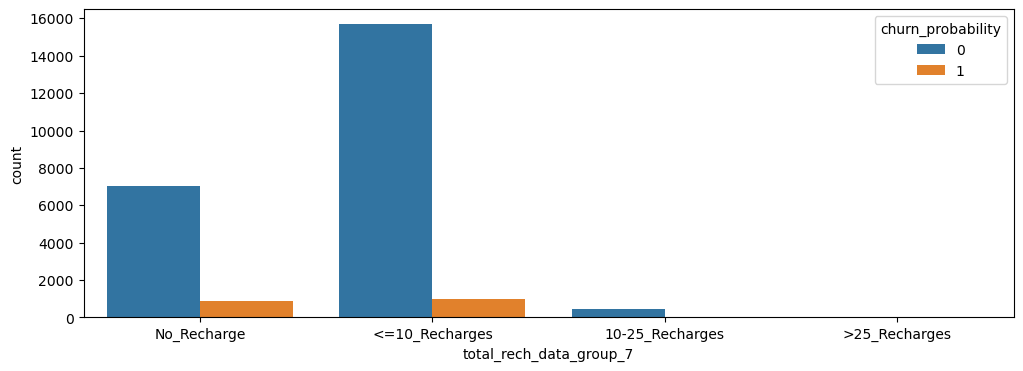


					Distribution of total_rech_data_6 variable
 total_rech_data_group_8
<=10_Recharges     17165
No_Recharge         7406
10-25_Recharges      476
>25_Recharges         33
Name: count, dtype: int64


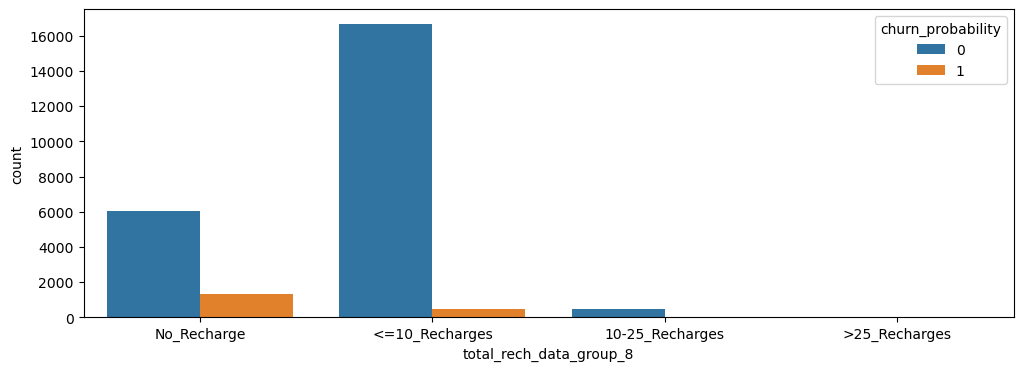

In [244]:
# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_6",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_6'].value_counts())
plt.show()
print("\n\n")
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_7",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_7'].value_counts())
plt.show("\n\n")
print()
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_data_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_data_6 variable\n",data['total_rech_data_group_8'].value_counts())
plt.show()

					Distribution of total_rech_num_6 variable
 total_rech_num_group_6
<=10_Recharges     17928
10-25_Recharges     6233
>25_Recharges        830
No_Recharge           89
Name: count, dtype: int64


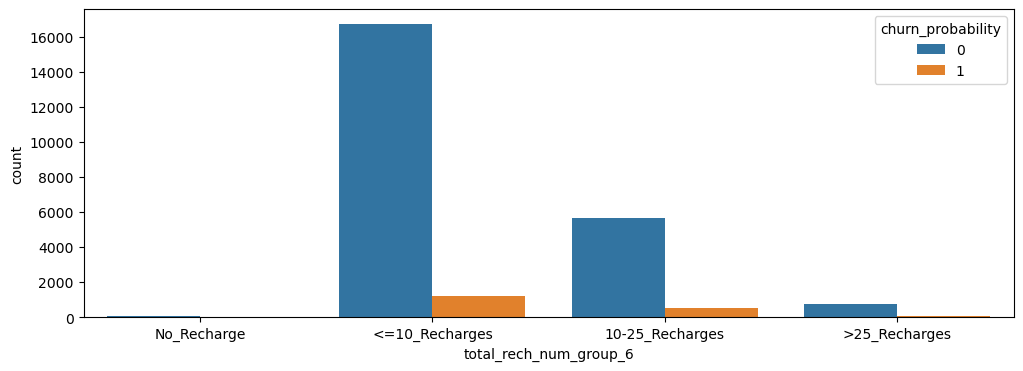




					Distribution of total_rech_num_7 variable
 total_rech_num_group_7
<=10_Recharges     17732
10-25_Recharges     6305
>25_Recharges        862
No_Recharge          181
Name: count, dtype: int64


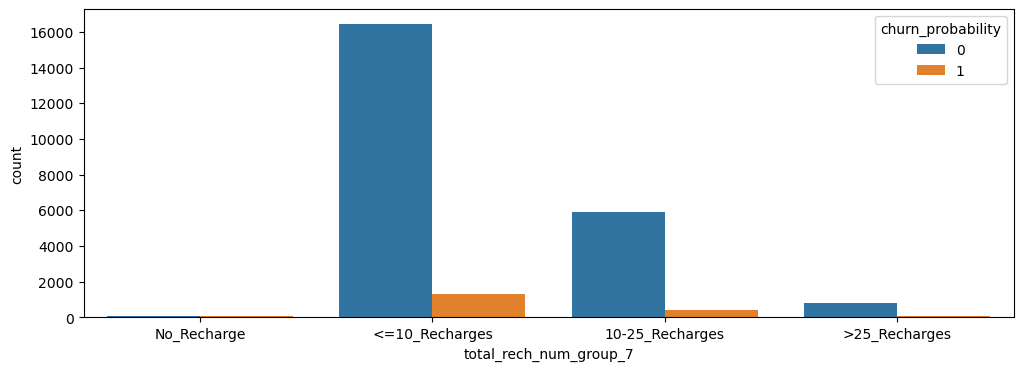


					Distribution of total_rech_num_8 variable
 total_rech_num_group_8
<=10_Recharges     17937
10-25_Recharges     5789
>25_Recharges        851
No_Recharge          503
Name: count, dtype: int64


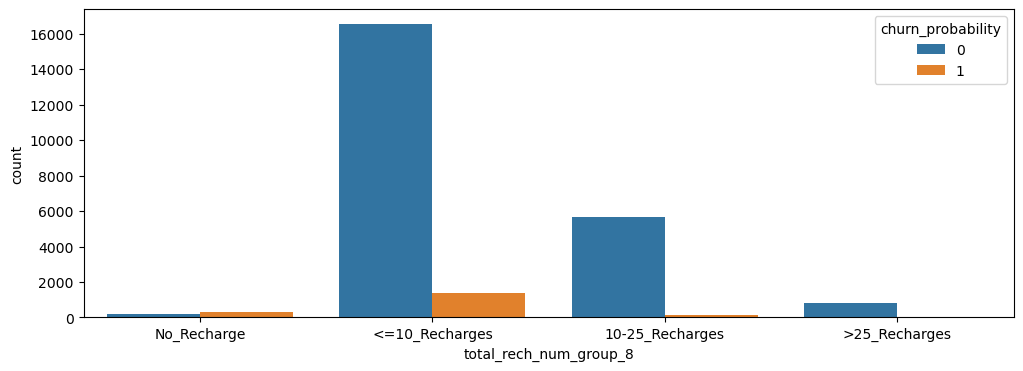

In [245]:
# Plotting the results

plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_num_group_6",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_num_6 variable\n",data['total_rech_num_group_6'].value_counts())
plt.show()
print("\n\n")
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_num_group_7",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_num_7 variable\n",data['total_rech_num_group_7'].value_counts())
plt.show("\n\n")
print()
plt.figure(figsize=[12,4])
sns.countplot(data=data,x="total_rech_num_group_8",hue="churn_probability")
print("\t\t\t\t\tDistribution of total_rech_num_8 variable\n",data['total_rech_num_group_8'].value_counts())
plt.show()

#### <span style="color:blue">Observation :-</span>
As the number of recharge rate increases, the churn rate decreases clearly.

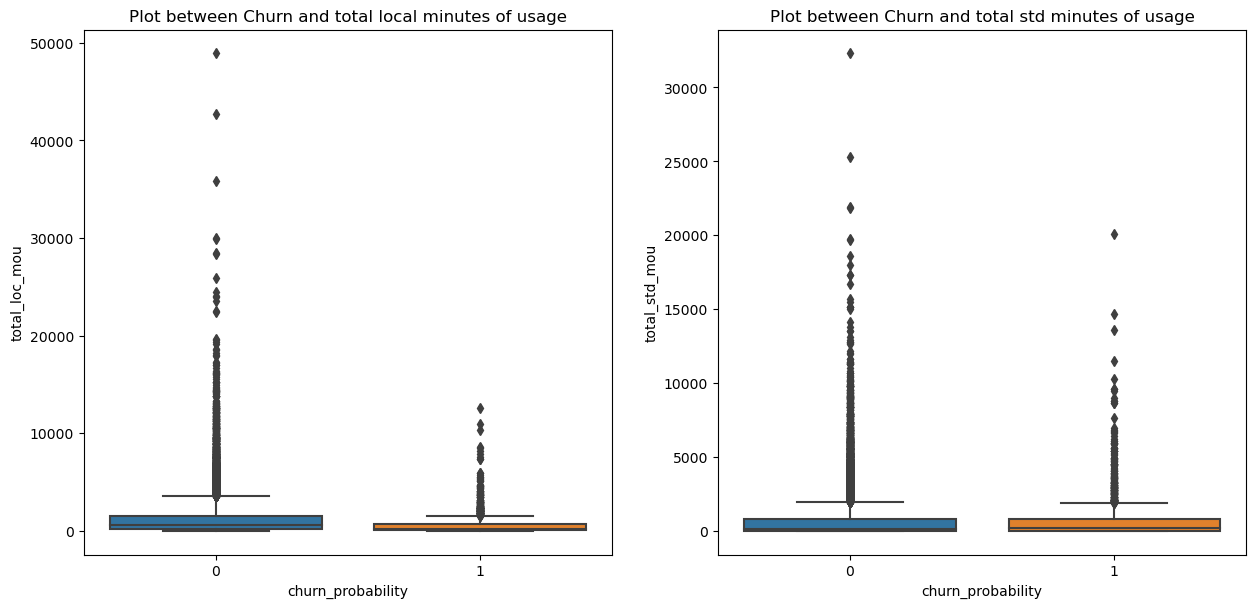

In [246]:
# Visualizing the churn variable with various predictor variables

#Plotting different varaible against churn
plt.figure(figsize=(15, 15))
plt.subplot(2,2,1)
sns.boxplot(x = 'churn_probability', y = 'total_loc_mou', data = data)
plt.title("Plot between Churn and total local minutes of usage")
plt.subplot(2,2,2)
sns.boxplot(x = 'churn_probability', y = 'total_std_mou', data = data)
plt.title("Plot between Churn and total std minutes of usage")
plt.show()

In [247]:
number_col = data.select_dtypes(include = ['int64','float64']).columns.tolist()
data[number_col].describe().T

,count,mean,std,min,25%,50%,75%,max
roam_ic_mou_6,25080.0,11.272862,61.730876,0.0,0.0000,0.000,0.0000,2613.31
roam_ic_mou_7,25080.0,8.180952,59.138248,0.0,0.0000,0.000,0.0000,2933.08
roam_ic_mou_8,25080.0,8.351919,62.008334,0.0,0.0000,0.000,0.0000,4169.81
roam_og_mou_6,25080.0,15.864240,83.203703,0.0,0.0000,0.000,0.0000,3775.11
roam_og_mou_7,25080.0,10.797617,62.114184,0.0,0.0000,0.000,0.0000,1900.06
roam_og_mou_8,25080.0,11.023522,72.475056,0.0,0.0000,0.000,0.0000,3493.36
loc_og_t2t_mou_6,25080.0,58.200660,193.441896,0.0,1.2000,12.260,46.1900,6431.33
loc_og_t2t_mou_7,25080.0,58.448136,203.552931,0.0,1.1100,11.785,46.1800,7400.66
loc_og_t2t_mou_8,25080.0,56.624229,204.602625,0.0,0.7500,11.200,45.3525,10752.56
loc_og_t2m_mou_6,25080.0,104.967124,183.923103,0.0,8.3300,42.785,125.9300,4696.83


In [248]:
data['monthly_2g_group_6']=pd.cut(data['monthly_2g_6'],[-1,0,3,100],labels=["No_Recharge","<=3_Recharges",">3_Recharges"])
data['monthly_2g_group_7']=pd.cut(data['monthly_2g_7'],[-1,0,3,100],labels=["No_Recharge","<=3_Recharges",">3_Recharges"])
data['monthly_2g_group_8']=pd.cut(data['monthly_2g_8'],[-1,0,3,100],labels=["No_Recharge","<=3_Recharges",">3_Recharges"])

data[['monthly_2g_6','monthly_2g_group_6','monthly_2g_7','monthly_2g_group_7','monthly_2g_8','monthly_2g_group_8']].head()

KeyError: 'monthly_2g_6'

In [249]:
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 25080 entries, 1 to 69998
Data columns (total 121 columns):
 #    Column                   Dtype   
---   ------                   -----   
 0    roam_ic_mou_6            float64 
 1    roam_ic_mou_7            float64 
 2    roam_ic_mou_8            float64 
 3    roam_og_mou_6            float64 
 4    roam_og_mou_7            float64 
 5    roam_og_mou_8            float64 
 6    loc_og_t2t_mou_6         float64 
 7    loc_og_t2t_mou_7         float64 
 8    loc_og_t2t_mou_8         float64 
 9    loc_og_t2m_mou_6         float64 
 10   loc_og_t2m_mou_7         float64 
 11   loc_og_t2m_mou_8         float64 
 12   loc_og_t2f_mou_6         float64 
 13   loc_og_t2f_mou_7         float64 
 14   loc_og_t2f_mou_8         float64 
 15   loc_og_t2c_mou_6         float64 
 16   loc_og_t2c_mou_7         float64 
 17   loc_og_t2c_mou_8         float64 
 18   loc_og_mou_6             float64 
 19   loc_og_mou_7             float64 
 20   loc_og_mo

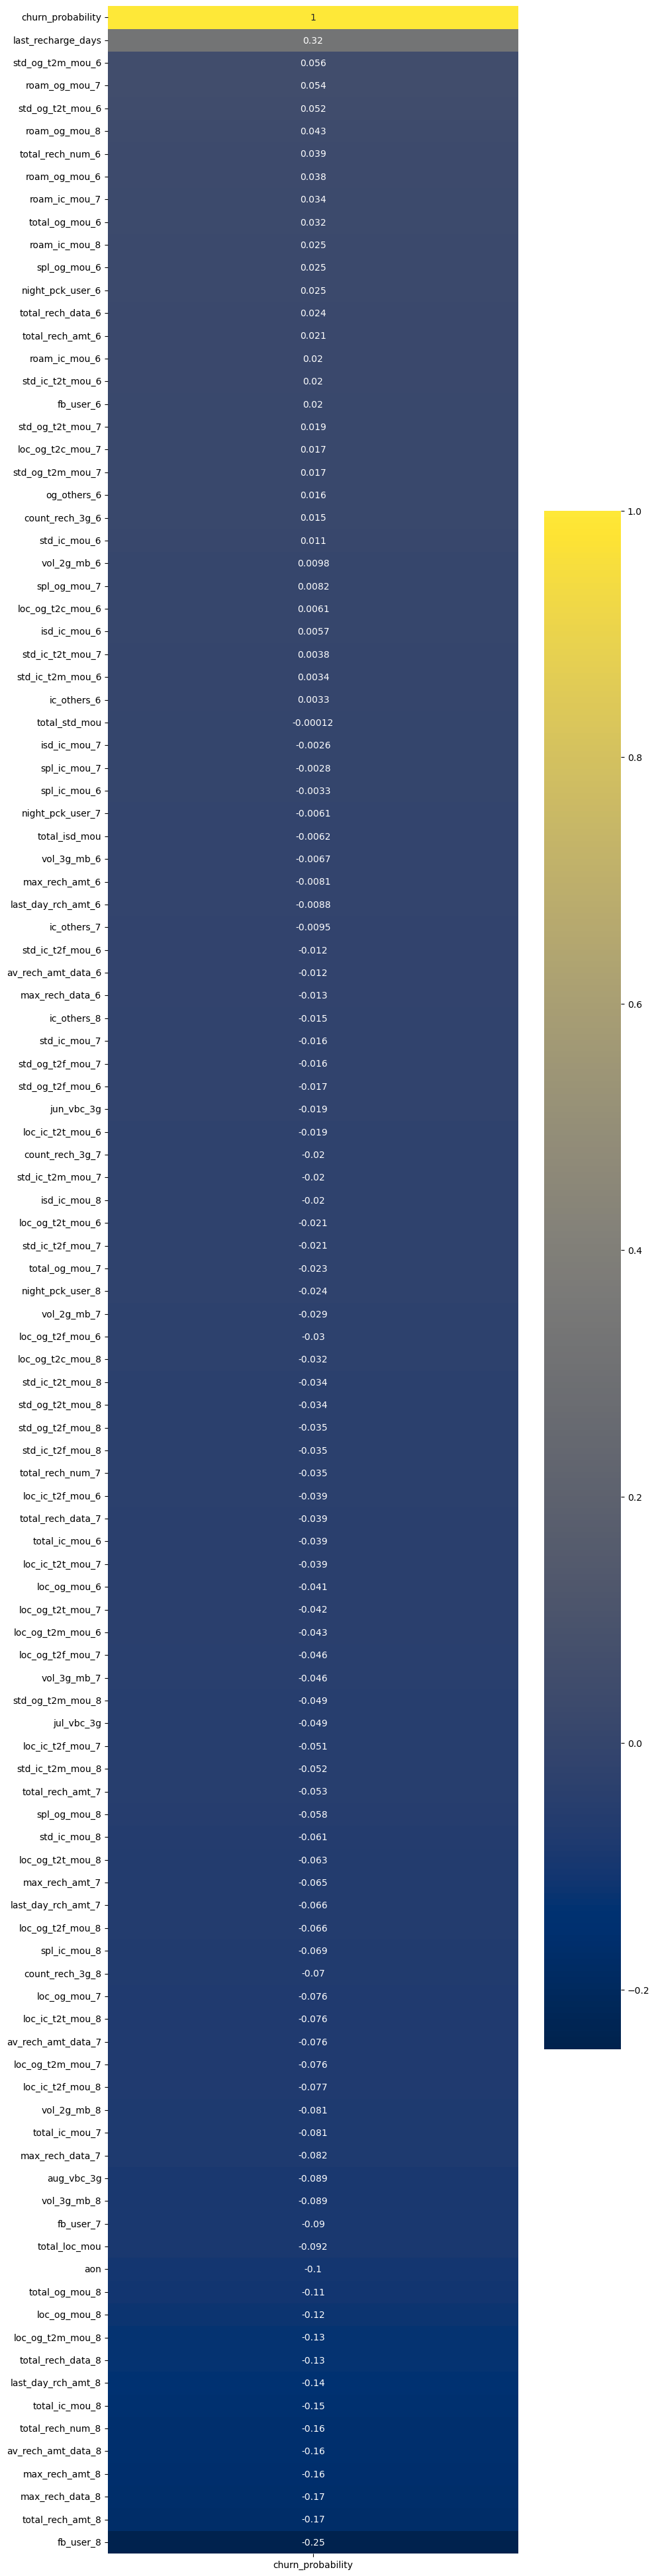

In [251]:
# Checking Correlation between target variable(Churn Probability) with the other variable in the dataset
plt.figure(figsize=(10,50))

numeric_data = data.select_dtypes(include=[np.number])
heatmap_churn = sns.heatmap(numeric_data.corr()[['churn_probability']].sort_values(ascending=False, by='churn_probability'), annot=True, cmap='cividis')

In [257]:
# Within our dataset, there is a column named 'aon' (Age on Network).


# We can generate additional variables to enhance our understanding of the data, particularly in relation to churn.

# Let's create a new variable called 'tenure' based on the number of months ('aon' divided by 30) and rounding to the nearest month.
data['tenure'] = (data['aon']/30).round(0)

# Now that we've derived the 'tenure' column from 'aon', we can safely drop it
data.drop('aon',axis=1, inplace=True)

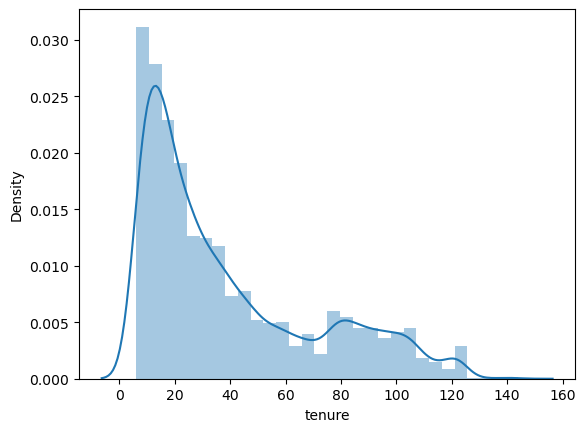

In [258]:
# To better visualize the distribution of the 'tenure' variable, we can plot it.

sns.distplot(data['tenure'],bins=30)
plt.show()

In [259]:
# created a range and divided it in different category
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data['tenure_range'] = pd.cut(data['tenure'], tn_range, labels=tn_label)
data['tenure_range'].head()

1     1-2 Yrs
4     1-2 Yrs
7     1-2 Yrs
10    1-2 Yrs
15    1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): ['0-6 Months' < '6-12 Months' < '1-2 Yrs' < '2-5 Yrs' < '5 Yrs and above']

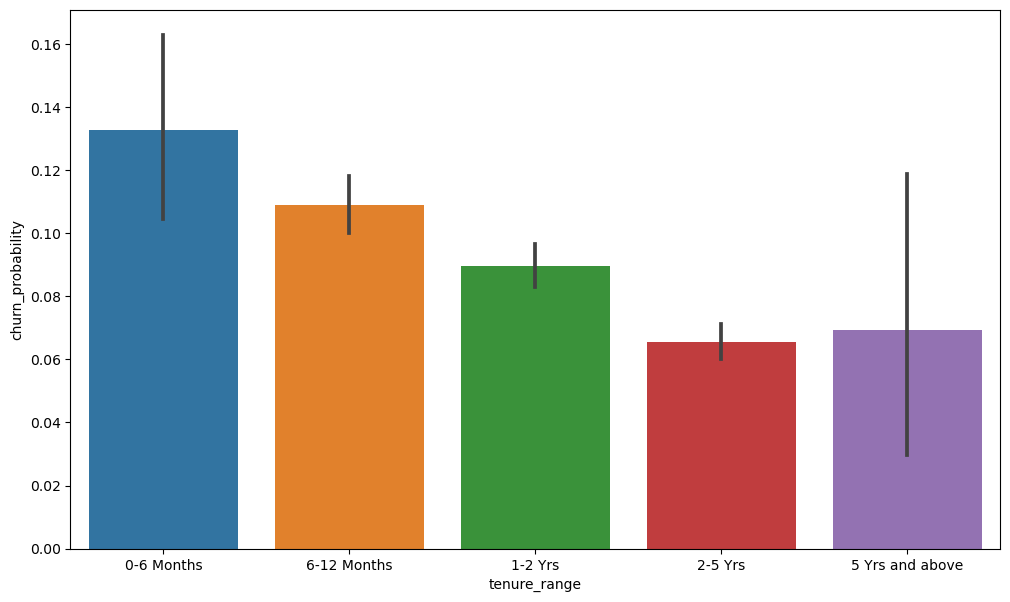

In [260]:
# Plotting a bar plot for tenure range
plt.figure(figsize=[12,7])
sns.barplot(x='tenure_range',y='churn_probability', data=data)
plt.show()

> <span style="color:blue">Observation</span> - People are churning more in 0-6 months of tenure

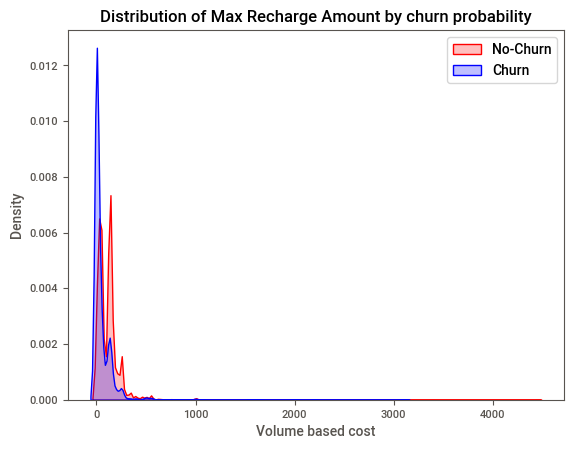

In [9]:
# Plot between churn vs max rechare amount
ax = sns.kdeplot(data.max_rech_amt_8[(data["churn_probability"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(data.max_rech_amt_8[(data["churn_probability"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["No-Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn probability')
plt.show()

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [ ]:
y = data.pop('churn_probability')
X = data

X.shape, y.shape

Splitting train and test data to avoid any contamination of the test data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

In [ ]:
X_train.head()

# 4. Exploratory Data Analysis & Preprocessing

Lets start by analysing the univariate distributions of each feature.

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train)

### 4.1 Handling outliers

The box plots of these features show there a lot of outliers. These can be capped with k-sigma method.

In [ ]:
def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [ ]:
X_train_filtered1 = X_train.apply(cap_outliers, axis=0)

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = X_train_filtered1)

### 4.2 Feature scaling

Lets also scale the features by scaling them with Standard scaler (few other alternates are min-max scaling and Z-scaling).

In [ ]:
new_vars = X_train_filtered1.columns

In [ ]:
scale = StandardScaler()
X_train_filtered2 = scale.fit_transform(X_train_filtered1)

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
sns.boxplot(data = pd.DataFrame(X_train_filtered2, columns=new_vars))

You can perform feature transformations at this stage. 

1. **Positively skewed:** Common transformations of this data include square root, cube root, and log.
2. **Negatively skewed:** Common transformations include square, cube root and logarithmic.

Please read the following link to understand how to perform feature scaling and preprocessing : https://scikit-learn.org/stable/modules/preprocessing.html
 
Lets also plot the correlations for each feature for bivariate analysis.

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(pd.DataFrame(X_train_filtered2, columns=new_vars).corr())

In [ ]:
#Distribution for the churn probability
sns.histplot(y_train)

# 5. Feature engineering and selection

Let's understand feature importances for raw features as well as components to decide top features for modelling.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X_train_filtered2, y_train)

In [ ]:
feature_importances = pd.DataFrame({'col':new_vars, 'importance':rf.feature_importances_})

In [ ]:
plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

At this step, you can create a bunch of features based on business understanding, such as 
1. "average % gain of 3g volume from month 6 to 8" - (growth or decline of 3g usage month over month?)
2. "ratio of total outgoing amount and age of user on network" - (average daily usage of a user?)
3. "standard deviation of the total amount paid by user for all services" - (too much variability in charges?)
4. etc..

Another way of finding good features would be to project them into a lower dimensional space using PCA. PCA creates components which are a linear combination of the features. This then allows you to select components which explain the highest amount of variance.

Lets try to project the data onto 2D space and plot. **Note:** you can try TSNE, which is another dimensionality reduction approach as well. Check https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html for moree details.

In [ ]:
pca = PCA(0.95)
pca_components = pca.fit_transform(X_train_filtered2)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)

In [ ]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)

In [ ]:
len(rf.feature_importances_)

In [ ]:
pca_components.shape

Let's also check which of the components have high feature importances towards the end goal of churn prediction.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(len(rf.feature_importances_))], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

# 6. Model building

Let's build a quick model with logistic regression and the first 2 PCA components.

# Linear Regression

The steps of this pipeline would be the following, but this is only one type of pipeline -
1. Imputation
2. Scaling
3. PCA
4. Classification model


In [ ]:
imp = SimpleImputer(strategy='constant', fill_value=0)
scale = StandardScaler()
pca = PCA(n_components=10, random_state=42)
lr = LogisticRegression(max_iter=1000, tol=0.001,random_state=42)

In [ ]:
pipe_lr = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',lr)])

In [ ]:
pipe_lr.fit(X_train[new_vars], y_train)

In [ ]:
train_score = pipe_lr.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe_lr.score(X_test[new_vars], y_test)
print("Test accuracy:", test_score)

Let's make a confusion matrix to analyze how each class is being predicted by the model.

In [ ]:
confusion_matrix(y_train, pipe_lr.predict(X_train[new_vars]))

In [ ]:
confusion_matrix(y_test, pipe_lr.predict(X_test[new_vars]))

We can see a high amount of type 2 error. Due to class imbalance, the model is clearly trying to predict majority of the cases as class 0. Understanding how to handle class imbalance in classification models might be the key to winning this competition :) (hint!)

In [ ]:
precision_score(y_test, pipe_lr.predict(X_test[new_vars]))

In [ ]:
recall_score(y_test, pipe_lr.predict(X_test[new_vars]))

# Random Forest

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline
# Define your pipeline
pipe_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('pca', PCA(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42))
])
# Define the parameter grid for GridSearchCV
# Define the parameter grid for GridSearchCV
param_grid = {
    'smote__sampling_strategy': [0.5, 0.75, 1.0], 
    'rf__n_estimators': [20, 30, 50],  # Adjust as needed
    'rf__max_depth': [10, 20, 30], # Adjust as needed
    # Add other parameters you want to tune
}

# Create the GridSearchCV object
grid_search = GridSearchCV(pipe_rf, param_grid, cv=5, scoring='accuracy')  # Adjust scoring and cv as needed

# Fit the model
grid_search.fit(X_train, y_train)

# Access the best parameters and best estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)
rf.fit(pca_components, y_train)

feature_importances = pd.DataFrame({'col':['component_'+str(i) for i in range(len(rf.feature_importances_))], 
                                    'importance':rf.feature_importances_})

plt.figure(figsize=(15,8))
plt.xticks(rotation=45)
plt.bar(feature_importances['col'], feature_importances['importance'])

In [ ]:
pipe_rf = Pipeline(steps = [('imputation',imp),
                         ('scaling',scale),
                         ('pca',pca),
                         ('model',rf)])

In [ ]:
pipe_rf.fit(X_train[new_vars], y_train)

In [ ]:
train_score = pipe_rf.score(X_train[new_vars], y_train)
print("Training accuracy:", train_score)

In [ ]:
test_score = pipe_rf.score(X_test[new_vars], y_test)
print("Testing accuracy:", test_score)

# 7. Creating submission file

For submission, we need to make sure that the format is exactly the same as the sample.csv file. It contains 2 columns, id and churn_probability

In [ ]:
sample.head()

The submission file should contain churn_probability values that have to be predicted for the unseen data provided (test.csv)

In [ ]:
unseen.head()

Lets first select the columns that we want to work with (or create them, if you have done any feature engineering)

In [ ]:
new_vars

In [ ]:
new_vars = [col for col in new_vars if col != 'churn']

In [ ]:
submission_data = unseen.set_index('id')[new_vars]
submission_data.shape

Next, lets create a new column in the unseen dataset called churn_probability and use the model pipeline to predict the probabilities for this data

In [ ]:
unseen['churn_probability'] = pipe_rf.predict(submission_data)
output = unseen[['id','churn_probability']]
output.head()

Finally, lets create a csv file out of this dataset, ensuring to set index=False to avoid an addition column in the csv.

In [ ]:
output.to_csv('submission.csv',index=False)

You can now take this file and upload it as a submission on Kaggle.

In [ ]:
output['churn_probability'].value_counts()